# Adjoint Plugin: 2 Checking Gradients

In this notebook, we will show how to use the adjoint plugin for `DiffractionMonitor` outputs and also check the gradient values against gradients obtained using transfer matrix method (TMM) to validate their accuracy for a multilayer slab problem.

In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import tmm
import matplotlib.pyplot as plt
from typing import Tuple, List

import tidy3d as td
from tidy3d.web import run as run_sim
from tidy3d.plugins.adjoint import JaxSimulation, JaxBox, JaxMedium, JaxStructure, JaxSimulationData
from tidy3d.plugins.adjoint.web import run as run_adjoint

[11:22:11] WARNING  This version of Tidy3D was pip installed from the 'tidy3d-beta' repository on   ]8;id=131947;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py\__init__.py]8;;\:]8;id=506553;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py#103\103]8;;\
                    PyPI. Future releases will be uploaded to the 'tidy3d' repository. From now on,                
                    please use 'pip install tidy3d' instead.                                                       

           INFO     Using client version: 1.9.0rc1                                                  ]8;id=512406;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py\__init__.py]8;;\:]8;id=815300;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py#121\121]8;;\

First, we define some global parameters describing the transmission through a multilayer slab with some spacing between each slab.

The layout is diagrammed below.

<img src="img/AdjointMultilayer.png" width=800>


In [2]:
# frequency we want to simulate at
freq0 = 2.0e14
k0 = 2 * np.pi * freq0 / td.C_0
freqs = [freq0]
wavelength = td.C_0 / freq0

# background permittivity
bck_eps = 1.3**2

# space between each slab
spc = 0.0

# slab permittivities and thicknesses
slab_eps0 = [2.**2, 1.8**2, 1.5**2, 1.9**2]
slab_ds0 = [0.5, 0.25, 0.5, 0.5]

# incidence angle
theta = 0 * np.pi/8

# resolution
dl = 0.01

## Transfer Matrix Method (Ground Truth)

Next we use the `tmm` package to write a function to return the transmission `T` of `p` polarized light given a set of slab permittivities and thicknesses. We'll also write a function to compute the numerical gradient using TMM and will take these to be our "ground truths" when evaluating the accuracy of our values obtained through FDTD and the adjoint plugin.

### Transmission Calculation with TMM

First, we write a function to compute transmission.

In [3]:
def compute_T_tmm(slab_eps=slab_eps0, slab_ds=slab_ds0) -> float:
    """Get transmission as a function of slab permittivities and thicknesses."""

    # construct lists of permittivities and thicknesses including spaces between
    new_slab_eps = []
    new_slab_ds = []
    for eps, d in zip(slab_eps, slab_ds):
        new_slab_eps.append(eps)
        new_slab_eps.append(bck_eps)
        new_slab_ds.append(d)
        new_slab_ds.append(spc)
    slab_eps = new_slab_eps[:-1]
    slab_ds = new_slab_ds[:-1]

    # add the input and output spaces to the lists
    eps_list = [bck_eps] + slab_eps + [bck_eps]
    n_list = np.sqrt(eps_list)    
    d_list = [np.inf] + slab_ds + [np.inf]
    
    # compute transmission with TMM
    return tmm.coh_tmm("p", n_list, d_list, theta, wavelength)["T"]

We run this function with our starting parameters and see that we get a transmission of about 98% for the set of input parameters.

In [4]:
T_tmm = compute_T_tmm(slab_eps=slab_eps0, slab_ds=slab_ds0)
print(f"T (tmm) = {T_tmm:.3f}")

T (tmm) = 0.901


### Numerical Gradient with TMM

Next, we will use our `compute_T_tmm()` function to compute the "numerical" gradient to use as comparison against our adjoint results with FDTD.

The derivative of a function $f(x)$ w.r.t. $x$ can be approximated using finite differences as

$$ \frac{df}{dx}(x) \approx \frac{f(x+\Delta) - f(x-\Delta)}{2\Delta}$$

with a small step $\Delta$.

To compute the gradient of our transmission with respect to each of the slab thicknesses and permittivities, we need to repeat this step for each of the values. Luckily, since TMM is very fast, we can compute these quantities quite quickly compared to if we were using FDTD.

> Important note: We assume in our TMM numerical gradient that when the slabs are touching (`spc=0`) and a slab thickness is modified, that the thicknesses of the neighboring slabs adjust to accomidate this change. For example, if slab `i` increases by `dt`, slab `i-1` and `i+1` each decrease by `dt/2`. We also account for this in our FDTD set up by keeping the centers of all boxes constant and not tracking the gradient through these quantities. The reason this is required is that `tidy3d.plugins.adjoint` does not recognize the space between touching `JaxBox` objects as a single interface and will instead "double count" the gradient contribution of the interface if they are placed right next to each other. One must therefore be careful about overlapping or touching two `JaxBox` or other geometries when computing gradients.

Here we write the function to return the numerical gradient.

In [5]:
def compute_grad_tmm(slab_eps=slab_eps0, slab_ds=slab_ds0) -> Tuple[List[float], List[float]]:
    """Compute numerical gradient of transmission w.r.t. each of the slab permittivities and thicknesses using TMM."""

    delta = 1e-4

    # set up containers to store gradient and perturbed arguments
    num_slabs = len(slab_eps)
    grad_tmm = np.zeros((2, num_slabs), dtype=float)
    args = np.stack((slab_eps, slab_ds), axis=0)

    # loop through slab index and argument index (eps, d)
    for arg_index in range(2):
        for slab_index in range(num_slabs):
            grad = 0.0
    
            # perturb the argument by delta in each + and - direction
            for pm in (-1, +1):
                args_num = args.copy()
                args_num[arg_index][slab_index] += delta * pm

                # NEW: for slab thickness gradient, need to modify neighboring slabs too
                if arg_index == 1 and spc == 0:
                    if slab_index > 0:
                        args_num[arg_index][slab_index - 1] -= delta * pm / 2
                    if slab_index < num_slabs - 1:
                        args_num[arg_index][slab_index + 1] -= delta * pm / 2
                
                # compute argument perturbed T and add to finite difference gradient contribution
                T_tmm = compute_T_tmm(slab_eps=args_num[0], slab_ds=args_num[1])
                grad += pm * T_tmm / 2 / delta        

            grad_tmm[arg_index][slab_index] = grad
    grad_eps, grad_ds = grad_tmm
    return grad_eps, grad_ds

Let's run this function and observe the gradients. These will be saved later to compare against our adjoint plugin results.

In [6]:
grad_eps_tmm, grad_ds_tmm = compute_grad_tmm()
print(f"gradient w.r.t. eps (tmm)  = {grad_eps_tmm}")
print(f"gradient w.r.t. ds  (tmm)  = {grad_ds_tmm}")

gradient w.r.t. eps (tmm)  = [-0.15463022  0.0376046  -0.0850184  -0.15883104]
gradient w.r.t. ds  (tmm)  = [-0.86661161 -0.12292531  0.58010922 -1.05537496]


## FDTD (Using adjoint plugin)

Next, we will implement the same two functions using Tidy3D's adjoint plugin.

### Transmission Calculation with FDTD

We first write a function to compute the transmission of a multilayer slab using Tidy3D.

As discussed in the previous adjoint tutorial notebook, we need to use `jax`-compatible components from the tidy3d subclass for any structures that may depend on the parameters. In this case, this means that the slabs must be `JaxStructures` containing `JaxBox` and `JaxMedium` and must be added to `JaxSimulation.input_structures`.

We use a `DiffractionMonitor` to measure our transmission amplitudes. As the data corresponding to this monitor will be used in the differentiable function return value, we must add it to `JaxSimulation.output_monitors`.

Below, we break up the transmission calculation into a few functions to make it easier to read and re-use later.

In [7]:
def make_sim(slab_eps=slab_eps0, slab_ds=slab_ds0) -> JaxSimulation:
    """Create a JaxSimulation given the slab permittivities and thicknesses."""

    # frequency setup
    wavelength = td.C_0 / freq0
    fwidth = freq0 / 10.0
    freqs = [freq0]

    # geometry setup
    bck_medium = td.Medium(permittivity=bck_eps)

    space_above = 2
    space_below = 2

    length_x = 0.1
    length_y = 0.1
    length_z = space_below + sum(slab_ds0) + space_above + (len(slab_ds0) - 1) * spc
    sim_size = (length_x, length_y, length_z)

    # make structures
    slabs = []
    z_start = -length_z/2 + space_below
    for (d, eps) in zip(slab_ds, slab_eps):

        # dont track the gradient through the center of each slab
        # as tidy3d doesn't have enough information to properly process the interface between touching JaxBox objects
        z_center = jax.lax.stop_gradient(z_start + d / 2) 
        slab = JaxStructure(
            geometry=JaxBox(center=[0, 0, z_center], size=[td.inf, td.inf, d]),
            medium=JaxMedium(permittivity=eps),
        )
        slabs.append(slab)
        z_start += d + spc

    # source setup
    gaussian = td.GaussianPulse(freq0=freq0, fwidth=fwidth)
    src_z = -length_z/2 + space_below/2.0

    source = td.PlaneWave(
        center=(0, 0, src_z),
        size=(td.inf, td.inf, 0),
        source_time=gaussian,
        direction="+",
        angle_theta=theta,
        angle_phi=0,
        pol_angle=0,
    )

    # boundaries
    boundary_x = td.Boundary.bloch_from_source(
        source=source, domain_size=sim_size[0], axis=0, medium=bck_medium
    )
    boundary_y = td.Boundary.bloch_from_source(
        source=source, domain_size=sim_size[1], axis=1, medium=bck_medium
    )    
    boundary_spec = td.BoundarySpec(x=boundary_x, y=boundary_y, z=td.Boundary.pml(num_layers=40))

    # monitors
    mnt_z = length_z/2 - space_above/2.0
    monitor_1 = td.DiffractionMonitor(
        center=[0.0, 0.0, mnt_z],
        size=[td.inf, td.inf, 0],
        freqs=freqs,
        name="diffraction",
        normal_dir="+",
    )

    # make simulation
    return JaxSimulation(
        size=sim_size,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=100),
        input_structures=slabs,
        sources=[source],
        output_monitors=[monitor_1],
        run_time= 10 / fwidth,
        boundary_spec=boundary_spec,
        medium=bck_medium,
        subpixel=True,
        shutoff=1e-8,
    )

Let's generate a simulation and plot it to make sure it looks reasonable.

           WARNING  'JaxSimulation.input_structures' elements 0 and 1 are overlapping or          ]8;id=555675;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=242971;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 1 and 2 are overlapping or          ]8;id=533883;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=778167;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 2 and 3 are overlapping or          ]8;id=794982;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=426881;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           INFO     Auto meshing using wavelength 1.4990 defined from sources.                     ]8;id=611705;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=714841;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py#510\510]8;;\

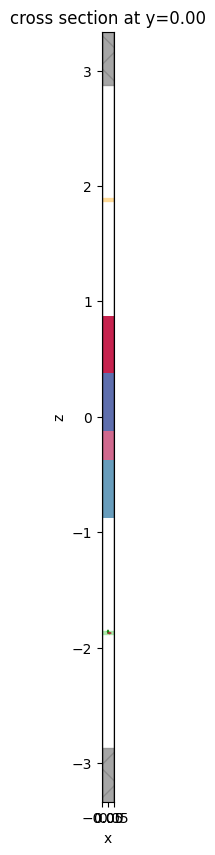

In [8]:
sim = make_sim()
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sim.plot(y=0, ax=ax)
plt.show()

Now we write a function to post process some run results to get the transmission we are after.

In [9]:
def post_process_T(sim_data: JaxSimulationData) -> float:
    """Given some JaxSimulationData from the run, return the transmission of "p" polarized light."""
    amps = sim_data.output_monitor_data["diffraction"].amps.sel(polarization="p")
    return jnp.sum(abs(amps.values)**2)

And finally, put everything together in a single function that relates the permittivities and thicknesses of each slab to the transmission, through a `JaxSimulation` run using the adjoint plugin.

In [10]:
def compute_T_fdtd(slab_eps=slab_eps0, slab_ds=slab_ds0) -> float:
    """Given the slab permittivities and thicknesses, compute T, making sure to use `tidy3d.plugins.adjoint.web.run_adjoint`."""
    sim = make_sim(slab_eps=slab_eps, slab_ds=slab_ds)
    sim_data = run_adjoint(sim, task_name='slab')
    return post_process_T(sim_data)

### Computing T and Gradient with FDTD

Now that we have this function defined, we are ready to compute our transmission and gradients using Tidy3d.

We first call `jax.value_and_grad()` on our transmission calculation function, which returns a function that will give us both `T` and the gradient of `T` with respect to the input parameters in one shot. For more details, see the previous tutorial.

In [11]:
compute_T_and_grad_fdtd = jax.value_and_grad(compute_T_fdtd, argnums=(0, 1))

Next, we call this function on our starting parameters, which will kick off the original (`fwd`) T transmission simulation and then the reverse (`adj`) simulation, which is used in combination with `fwd` for the gradient calculation.

In [12]:
T_fdtd, (grad_eps_fdtd, grad_ds_fdtd) = compute_T_and_grad_fdtd(slab_eps0, slab_ds0)

           INFO     Remote TPU is not linked into jax; skipping remote TPU.                       ]8;id=147120;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py\xla_bridge.py]8;;\:]8;id=394611;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py#160\160]8;;\

           INFO     Unable to initialize backend 'tpu_driver': Could not initialize backend       ]8;id=536666;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py\xla_bridge.py]8;;\:]8;id=801510;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py#333\333]8;;\
                    'tpu_driver'                                                                                   

           INFO     Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no     ]8;id=892887;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py\xla_bridge.py]8;;\:]8;id=545833;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py#333\333]8;;\
                    attribute 'GpuAllocatorConfig'                                                                 

           INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no     ]8;id=386591;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py\xla_bridge.py]8;;\:]8;id=577322;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py#333\333]8;;\
                    attribute 'GpuAllocatorConfig'                                                                 

           INFO     Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no      ]8;id=529943;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py\xla_bridge.py]8;;\:]8;id=595311;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py#333\333]8;;\
                    attribute 'get_tpu_client'                                                                     

           WARNING  'JaxSimulation.input_structures' elements 0 and 1 are overlapping or          ]8;id=642266;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=188196;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 1 and 2 are overlapping or          ]8;id=893611;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=153325;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 2 and 3 are overlapping or          ]8;id=532469;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=688856;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 0 and 1 are overlapping or          ]8;id=522016;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=331402;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 1 and 2 are overlapping or          ]8;id=991697;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=835096;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 2 and 3 are overlapping or          ]8;id=527655;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=348078;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 0 and 1 are overlapping or          ]8;id=732109;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=120591;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 1 and 2 are overlapping or          ]8;id=157276;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=386035;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 2 and 3 are overlapping or          ]8;id=872658;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=119787;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 0 and 1 are overlapping or          ]8;id=406279;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=765179;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 1 and 2 are overlapping or          ]8;id=890222;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=730292;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 2 and 3 are overlapping or          ]8;id=249522;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=243872;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           INFO     Auto meshing using wavelength 1.4990 defined from sources.                     ]8;id=301480;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=181793;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py#510\510]8;;\

[11:22:12] INFO     Created task 'slab_fwd' with task_id '0c0b4861-d0c2-4717-93cc-a841603c730d'.      ]8;id=419074;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=602189;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[11:22:15] INFO     Maximum FlexUnit cost: 0.025                                                      ]8;id=769872;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=391835;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#253\253]8;;\

           INFO     status = queued                                                                   ]8;id=628687;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=671984;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#262\262]8;;\

Output()

[11:22:18] INFO     status = preprocess                                                               ]8;id=395272;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=653774;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#274\274]8;;\

[11:22:21] INFO     starting up solver                                                                ]8;id=815221;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=781866;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#278\278]8;;\

[11:22:31] INFO     running solver                                                                    ]8;id=57714;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=577777;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#284\284]8;;\

Output()

[11:22:34] INFO     early shutoff detected, exiting.                                                  ]8;id=28526;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=774913;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#295\295]8;;\

           INFO     status = postprocess                                                              ]8;id=908197;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=581664;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#301\301]8;;\

Output()

[11:22:36] INFO     status = success                                                                  ]8;id=33265;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=789616;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#307\307]8;;\

           INFO     Billed FlexUnit cost: 0.025                                                       ]8;id=328335;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=46182;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to "simulation_data.hdf5"             ]8;id=883438;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=809330;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#593\593]8;;\

Output()

[11:22:39] INFO     loading SimulationData from simulation_data.hdf5                                  ]8;id=475833;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=763910;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#415\415]8;;\

           WARNING  'JaxSimulation.input_structures' elements 0 and 1 are overlapping or          ]8;id=790561;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=66900;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 1 and 2 are overlapping or          ]8;id=118626;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=21271;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 2 and 3 are overlapping or          ]8;id=310798;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=701108;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 0 and 1 are overlapping or          ]8;id=809439;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=670649;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 1 and 2 are overlapping or          ]8;id=605932;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=423904;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 2 and 3 are overlapping or          ]8;id=185955;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=268463;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 0 and 1 are overlapping or          ]8;id=792043;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=98659;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 1 and 2 are overlapping or          ]8;id=32976;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=806319;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 2 and 3 are overlapping or          ]8;id=891750;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=426777;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 0 and 1 are overlapping or          ]8;id=300029;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=21607;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 1 and 2 are overlapping or          ]8;id=18886;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=655055;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 2 and 3 are overlapping or          ]8;id=947741;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=54468;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 0 and 1 are overlapping or          ]8;id=322684;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=26622;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 1 and 2 are overlapping or          ]8;id=339161;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=438638;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 2 and 3 are overlapping or          ]8;id=216849;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=602360;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 0 and 1 are overlapping or          ]8;id=780981;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=194022;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 1 and 2 are overlapping or          ]8;id=207002;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=605378;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 2 and 3 are overlapping or          ]8;id=49746;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=903114;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 0 and 1 are overlapping or          ]8;id=54628;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=142958;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 1 and 2 are overlapping or          ]8;id=885745;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=621317;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 2 and 3 are overlapping or          ]8;id=148466;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=186982;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 0 and 1 are overlapping or          ]8;id=356621;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=757198;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 1 and 2 are overlapping or          ]8;id=915942;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=1118;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 2 and 3 are overlapping or          ]8;id=775149;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=749227;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           INFO     Auto meshing using wavelength 1.4990 defined from sources.                     ]8;id=359146;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=752118;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py#510\510]8;;\

           INFO     Created task 'slab_adj' with task_id 'a3846f9b-6cb3-49f2-8869-c0df8893aeab'.      ]8;id=546258;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=647303;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[11:22:42] INFO     Maximum FlexUnit cost: 0.025                                                      ]8;id=374990;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=808505;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#253\253]8;;\

           INFO     status = queued                                                                   ]8;id=189155;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=747101;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#262\262]8;;\

Output()

[11:22:44] INFO     status = preprocess                                                               ]8;id=729841;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=208337;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#274\274]8;;\

[11:22:48] INFO     starting up solver                                                                ]8;id=268159;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=310436;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#278\278]8;;\

[11:22:55] INFO     running solver                                                                    ]8;id=315813;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=555184;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#284\284]8;;\

Output()

[11:22:57] INFO     early shutoff detected, exiting.                                                  ]8;id=31870;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=712040;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#295\295]8;;\

           INFO     status = postprocess                                                              ]8;id=412374;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=690281;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#301\301]8;;\

Output()

[11:23:00] INFO     status = success                                                                  ]8;id=824697;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=329329;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#307\307]8;;\

[11:23:01] INFO     Billed FlexUnit cost: 0.025                                                       ]8;id=369915;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=633858;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to "simulation_data.hdf5"             ]8;id=141105;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=484378;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#593\593]8;;\

Output()

[11:23:03] INFO     loading SimulationData from simulation_data.hdf5                                  ]8;id=513766;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=292416;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#415\415]8;;\

           WARNING  'JaxSimulation.input_structures' elements 0 and 1 are overlapping or          ]8;id=386720;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=759567;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 1 and 2 are overlapping or          ]8;id=349180;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=892543;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 2 and 3 are overlapping or          ]8;id=137411;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=324159;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 0 and 1 are overlapping or          ]8;id=717443;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=788090;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 1 and 2 are overlapping or          ]8;id=103510;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=803322;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 2 and 3 are overlapping or          ]8;id=87290;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=472966;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 0 and 1 are overlapping or          ]8;id=940936;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=841757;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 0 and 2 are overlapping or          ]8;id=609290;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=58883;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 1 and 2 are overlapping or          ]8;id=654750;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=428243;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 0 and 3 are overlapping or          ]8;id=67662;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=941052;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 1 and 3 are overlapping or          ]8;id=483515;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=730881;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

           WARNING  'JaxSimulation.input_structures' elements 2 and 3 are overlapping or          ]8;id=876188;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=364439;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#132\132]8;;\
                    touching. Geometric gradients for overlapping structures may contain errors.                   

### Checking Accuracy of TMM (Numerical) vs FDTD (Adjoint)

Let's convert these from jax types to numpy arrays to work with them easier, and then display the results compared to TMM.

In [13]:
grad_eps_fdtd = np.array(grad_eps_fdtd)
grad_ds_fdtd = np.array(grad_ds_fdtd)

In [14]:
print(f"T (tmm)  = {T_tmm:.5f}")
print(f"T (FDTD) = {T_fdtd:.5f}")

T (tmm)  = 0.90105
T (FDTD) = 0.90048


We see that the transmission results match very well with TMM, giving us a lot of confidence that our set up is correct.

Let's look at the gradients now.

In [15]:
print("un-normalized:")
print(f"\tgrad_eps (tmm)  = {grad_eps_tmm}")
print(f"\tgrad_eps (FDTD)  = {grad_eps_fdtd}")
print(80*'-')
print(f"\tgrad_ds  (tmm)  = {grad_ds_tmm}")
print(f"\tgrad_ds  (FDTD)  = {grad_ds_fdtd}")


rms_eps = np.linalg.norm(grad_eps_tmm - grad_eps_fdtd) / np.linalg.norm(grad_eps_tmm)
rms_ds = np.linalg.norm(grad_ds_tmm - grad_ds_fdtd) / np.linalg.norm(grad_ds_tmm)

print(f"RMS error = {rms_eps * 100} %")
print(f"RMS error = {rms_ds * 100} %")

un-normalized:
	grad_eps (tmm)  = [-0.15463022  0.0376046  -0.0850184  -0.15883104]
	grad_eps (FDTD)  = [-0.1555976   0.03868869 -0.08492474 -0.15971336]
--------------------------------------------------------------------------------
	grad_ds  (tmm)  = [-0.86661161 -0.12292531  0.58010922 -1.05537496]
	grad_ds  (FDTD)  = [-0.86666322 -0.12288866  0.58089763 -1.05617058]
RMS error = 0.7082491898399449 %
RMS error = 0.07535549363258941 %


The gradients match to < 1% of their respective norms, which is very good agreement.

If we only care about the error in the "directions" of the gradients, we can compare their normalized versions to each other.

In [16]:
def normalize(arr):
    return arr / np.linalg.norm(arr)

grad_eps_tmm_norm = normalize(grad_eps_tmm)
grad_ds_tmm_norm = normalize(grad_ds_tmm)
grad_eps_fdtd_norm = normalize(grad_eps_fdtd)
grad_ds_fdtd_norm = normalize(grad_ds_fdtd)

rms_eps = np.linalg.norm(grad_eps_tmm_norm - grad_eps_fdtd_norm) / np.linalg.norm(grad_eps_tmm_norm)
rms_ds = np.linalg.norm(grad_ds_tmm_norm - grad_ds_fdtd_norm) / np.linalg.norm(grad_ds_tmm_norm)

In [17]:
print("normalized:")
print(f"\tgrad_eps (tmm)  = {grad_eps_tmm_norm}")
print(f"\tgrad_eps (FDTD)  = {grad_eps_fdtd_norm}")
print(f"\tRMS error = {rms_eps * 100} %")
print(80*'-')
print(f"\tgrad_ds  (tmm)  = {grad_ds_tmm_norm}")
print(f"\tgrad_ds  (FDTD)  = {grad_ds_fdtd_norm}")
print(f"\tRMS error = {rms_ds * 100} %")

normalized:
	grad_eps (tmm)  = [-0.64328803  0.15644151 -0.35369102 -0.66076412]
	grad_eps (FDTD)  = [-0.64371317  0.16005659 -0.35133688 -0.66074022]
	RMS error = 0.4334980715866199 %
--------------------------------------------------------------------------------
	grad_ds  (tmm)  = [-0.58209469 -0.08256775  0.38965379 -0.70888522]
	grad_ds  (FDTD)  = [-0.58177829 -0.08249335  0.38994805 -0.70899181]
	RMS error = 0.04512126664001993 %


In which case we see slight improvement, but the unnormalized gradients already match quite well before this.